# 2-Cell and 3-Cell Motifs in PyC Subgraph (Th=300)

In [1]:
import os
import random
from time import time
import pandas as pd
import numpy as np
import networkx as nx

from utils.graph_creation import *
from utils.motif_counts import *
from utils.visualization import *

## Create PyC Subgraph

In [2]:
pyc_synapses = pd.read_csv('data/synapses.csv')
pyc_synapses

,pre,post
0,648518346349539437,648518346349531254
1,648518346349537978,648518346349537300
2,648518346349533058,648518346349538715
3,648518346349539333,648518346349539806
4,648518346349523975,648518346349537716
...,...,...
1976,648518346349539110,648518346349538440
1977,648518346349539110,648518346349523993
1978,648518346349539110,648518346349524141
1979,648518346349539110,648518346349539900


In [3]:
pyc_soma = pd.read_csv('data/soma.csv')
pyc_soma

,segmentation,segment_id,manual_id,loc,axon_len,dendrite_len
0,185,648518346349491311,466,[314028 159940 77280],0.000000,1441.069000
1,185,648518346349492130,499,[291484 145484 80960],0.000000,747.483938
2,185,648518346349492197,503,[270948 158088 86240],0.000000,586.186063
3,185,648518346349492682,163,[461372 212624 27640],643.547438,979.816375
4,185,648518346349493472,549,[431864 156576 85720],0.000000,0.000000
...,...,...,...,...,...,...
358,185,648518346349540048,80,[349132 163492 11480],961.385250,1321.124250
359,185,648518346349540051,259,[444892 247424 47480],61.243563,1999.626500
360,185,648518346349540053,102,[446104 253936 18320],56.518617,1612.330500
361,185,648518346349540055,139,[340468 248332 23400],46.961094,3101.869750


In [4]:
# create the simple directed graph (no self-loops, no multi-edges)
# treat multiple synapses as one connection
pyc_subgraph = synapses_to_connections(pyc_synapses[['pre','post']])
# remove self-loops
g_actual = remove_autapses(edges_to_graph(pyc_subgraph))
g_actual.add_nodes_from(pyc_soma["segment_id"])

In [5]:
print(nx.info(g_actual))

Name: 
Type: DiGraph
Number of nodes: 363
Number of edges: 1750
Average in degree:   4.8209
Average out degree:   4.8209


In [7]:
axls = {n:np.array(pyc_soma[pyc_soma["segment_id"] == n]["axon_len"])[0] for n in g_actual.nodes()}

In [8]:
g_th300 = get_thresholded_graph(g_actual, axls, 300)
print(nx.info(g_th300))

Name: 
Type: DiGraph
Number of nodes: 100
Number of edges: 622
Average in degree:   6.2200
Average out degree:   6.2200


## 2-Cell Motifs

In [9]:
%%time
# count 2-cell motifs in the observation
obs_two_counts = count_two_neuron_motifs_graph(g_th300)
# analytically compute 2-cell motif counts in Erdos-Renyi model
er_two_counts = compute_ER_two_neuron_motifs(g_th300)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.47 ms


In [10]:
%%time
s=100 # total 1000 samples (10 workers x 100 continous samples)
config_two_counts = sample_motifs_parallel_continuous(continuous_sample_two_neuron_motifs, g_th300, samples=s, niters=int(1e4), threads=10)

CPU times: user 80 ms, sys: 68 ms, total: 148 ms
Wall time: 33.9 s


connect probability =  0.06282828282828283


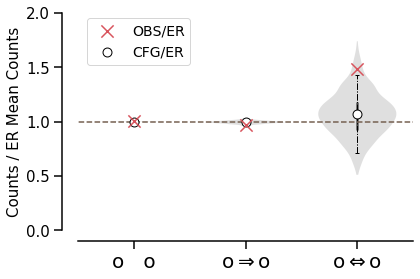

In [11]:
# relative counts in ratio (/ER expected counts)
res_two = plot_two_neuron_counts_violin(obs_two_counts, er_two_counts, config_two_counts, ylim=(0, 2), fname="th300/th300_2_violin");

In [12]:
res_two

,obs,er_exp,config_exp,config_std,config_z
actual_edges,NaN,NaN,622.000,0.000000,NaN
autapses,NaN,NaN,0.000,0.000000,NaN
bi,29.0,19.539596,20.948,4.083132,1.972016
neurons,NaN,NaN,100.000,0.000000,NaN
null,4357.0,4347.539596,4348.948,4.083132,1.972016
potential_edges,NaN,NaN,9900.000,0.000000,NaN
uni,564.0,582.920808,580.104,8.166264,-1.972016


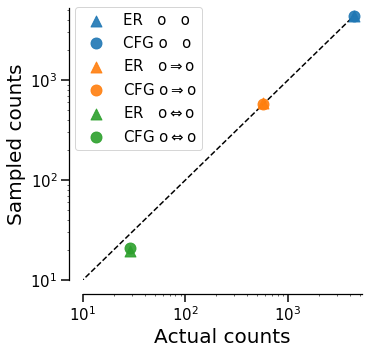

In [13]:
plot_two_neuron_counts_scatter(obs_two_counts, er_two_counts, config_two_counts, figsize=(5,5), fname="th300/th300_2_scatter")

In [14]:
# p-values
np.minimum((config_two_counts > obs_two_counts).sum(0) / 1000, 
           (config_two_counts < obs_two_counts).sum(0) / 1000)

neurons            0.000
autapses           0.000
actual_edges       0.000
uni                0.027
bi                 0.027
potential_edges    0.000
null               0.027
dtype: float64

## 3-Cell Motifs

In [15]:
%%time
# count 3-cell motifs in the observation
obs_three_counts, _ = count_three_neuron_motifs(*graph_to_sets(g_th300), motifs)
# analytically compute 2-cell motif counts in Erdos-Renyi model
three_pr, two_pr = compute_three_neuron_motif_probabilities(g_th300)
er_three_counts = compute_expected_three_neuron_motifs(g_th300, three_pr)

CPU times: user 11.9 s, sys: 12 ms, total: 11.9 s
Wall time: 11.9 s


In [16]:
%%time
s=100 # total 1000 samples (10 workers x 100 continous samples)
config_three_counts = sample_motifs_parallel_continuous(continuous_sample_three_neuron_motifs, g_th300, samples=s, niters=int(1e4), threads=10)

CPU times: user 192 ms, sys: 44 ms, total: 236 ms
Wall time: 1h 2min 18s


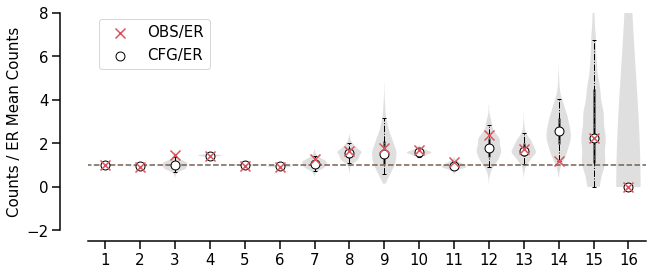

In [17]:
# relative counts in ratio (/ER expected counts)
res_three = plot_three_neuron_counts_violin(obs_three_counts, er_three_counts, config_three_counts, 
                                            subtitle='', ylim=[-2, 8], fname="th300/th300_3_violin", figsize=(10,4))

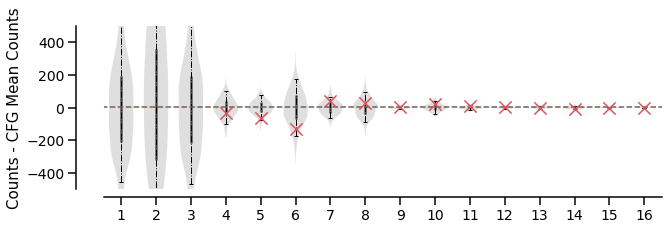

In [18]:
# relative counts in difference (-CFG expected counts)
plot_three_neuron_counts_diff_violin(obs_three_counts, er_three_counts, config_three_counts, 
                                     subtitle='', ylim=[-500, 500], fname="th300/th300_3_violin_diff");

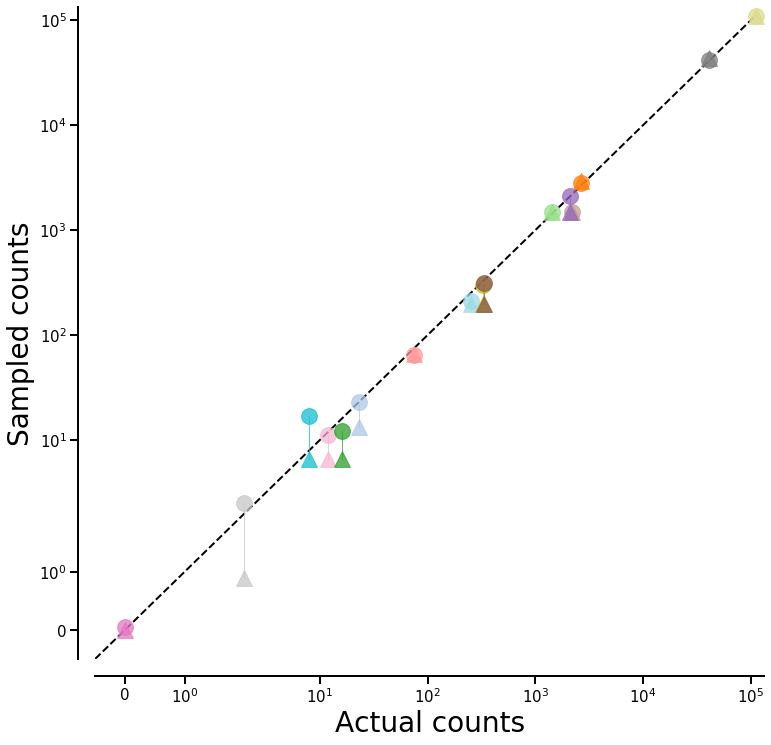

In [19]:
plot_three_neuron_counts_scatter(obs_three_counts, er_three_counts, config_three_counts, figsize=(12,12), fname="th300/th300_3_scatter")

In [20]:
res_three

,obs,er_exp,config_exp,config_std,config_z
1,111292,109553.198433,110636.038,287.113390,2.284679
2,40979,44066.882577,42199.025,483.211392,-2.524827
3,2182,1477.128743,1490.058,298.341234,2.319297
4,2100,1477.128743,2134.239,61.830194,-0.553759
5,1427,1477.128743,1489.519,44.338669,-1.410033
6,2664,2954.257487,2792.340,106.493461,-1.205144
7,255,198.054339,212.357,41.850341,1.018940
8,330,198.054339,302.858,57.647594,0.470826
9,12,6.638812,11.063,5.296138,0.176921
10,335,198.054339,313.592,22.528006,0.950284


In [21]:
# p-values
np.minimum((config_three_counts > obs_three_counts).sum(0) / 1000, 
           (config_three_counts < obs_three_counts).sum(0) / 1000)

1     0.016
2     0.006
3     0.012
4     0.279
5     0.081
6     0.105
7     0.142
8     0.299
9     0.345
10    0.167
11    0.112
12    0.135
13    0.433
14    0.036
15    0.331
16    0.000
dtype: float64

## 3-Cell Motifs (Generalized ER and CFG)

In [22]:
%%time
# analytically compute 2-cell motif counts in Erdos-Renyi model
three_pr_GE, two_pr_GE = compute_three_neuron_motif_probabilities_GE(g_th300)
er_three_counts_GE = compute_expected_three_neuron_motifs(g_th300, three_pr_GE)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.26 ms


In [23]:
%%time
s=100 # total 1000 samples (10 workers x 100 continous samples)
config_three_counts_GE = sample_motifs_parallel_continuous(continuous_sample_three_neuron_motifs_GE, g_th300, samples=s, niters=int(1e4), threads=10)

CPU times: user 156 ms, sys: 72 ms, total: 228 ms
Wall time: 1h 12min 23s


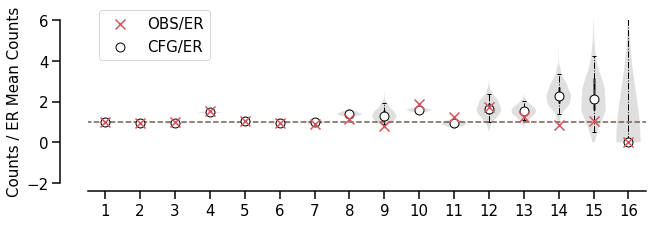

In [24]:
# relative counts in ratio (/ER expected counts)
res_three_GE = plot_three_neuron_counts_violin(obs_three_counts, er_three_counts_GE, config_three_counts_GE, 
                                            subtitle='', ylim=[-2, 6], fname="th300/th300_3_violin_GE", figsize=(10,3))

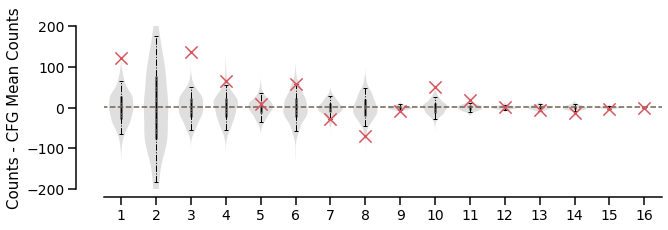

In [25]:
# relative counts in difference (-CFG expected counts)
plot_three_neuron_counts_diff_violin(obs_three_counts, er_three_counts_GE, config_three_counts_GE, 
                                     subtitle='', ylim=[-200, 200], fname="th300/th300_3_violin_diff_GE");

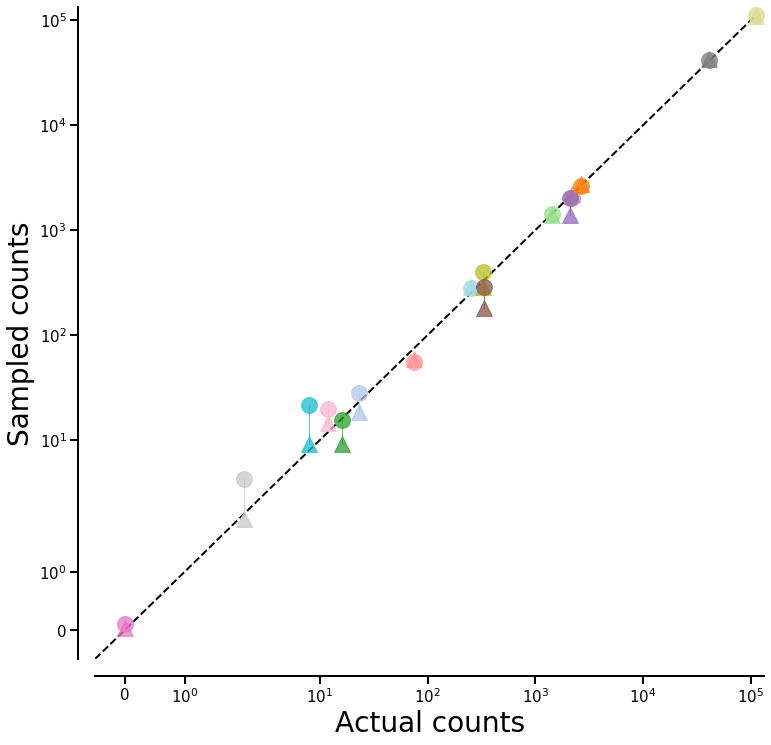

In [26]:
plot_three_neuron_counts_scatter(obs_three_counts, er_three_counts_GE, config_three_counts_GE, 
                                 figsize=(12,12), fname="th300/th300_3_scatter_GE")

In [27]:
res_three_GE

,obs,er_exp,config_exp,config_std,config_z
1,111292,110269.931024,111169.692,39.078412,3.129810
2,40979,42822.291322,41312.174,108.067962,-3.083004
3,2182,2201.855405,2045.257,32.334788,4.228975
4,2100,1385.802864,2034.362,34.458269,1.904855
5,1427,1385.802864,1419.021,21.417966,0.372538
6,2664,2771.605727,2606.115,35.088959,1.649664
7,255,285.023284,282.072,16.978430,-1.594494
8,330,285.023284,400.627,29.560915,-2.389202
9,12,14.655453,19.865,4.507226,-1.744976
10,335,179.387839,285.170,16.386690,3.040882


In [28]:
# p-values
np.minimum((config_three_counts_GE > obs_three_counts).sum(0) / 1000, 
           (config_three_counts_GE < obs_three_counts).sum(0) / 1000)

1     0.000
2     0.000
3     0.000
4     0.028
5     0.348
6     0.048
7     0.057
8     0.007
9     0.013
10    0.000
11    0.006
12    0.398
13    0.138
14    0.002
15    0.074
16    0.000
dtype: float64

## Clustering Coefficient

In [29]:
# clustering coefficient of the observed network
nx.transitivity(g_th300.to_undirected())

0.16864666258420086

In [30]:
# expected clustering coefficient of the networsk sampled from the ER model
1-two_pr['pr_null']

0.12170917253341484

In [31]:
# expected clustering coefficient of the networsk sampled from the CFG model
clustering_coef(config_three_counts).mean()

0.15744014163082984

In [32]:
# expected clustering coefficient of the networsk sampled from the generalized ER model
1-two_pr_GE['pr_null']

0.11979797979797979

In [33]:
# expected clustering coefficient of the networsk sampled from the generalized CFG model
clustering_coef(config_three_counts_GE).mean()

0.15415617622002864

## Generate Plots

connect probability =  0.06282828282828283


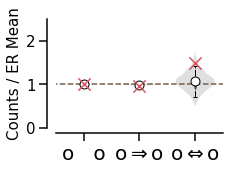

In [38]:
plot_two_neuron_counts_violin_adapt(obs_two_counts, er_two_counts, config_two_counts, ylim=(0, 2.5), figsize=(3,2), fname="th300/th300_2_violin");

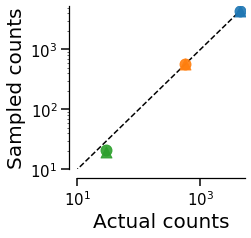

In [39]:
plot_two_neuron_counts_scatter_adapt(obs_two_counts, er_two_counts, config_two_counts, figsize=(3,3), fname="th300/th300_2_scatter");

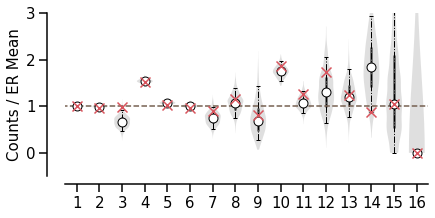

In [45]:
res_three_CGE = plot_three_neuron_counts_violin_adapt(obs_three_counts, er_three_counts_GE, config_three_counts, 
                                            subtitle='', ylim=[-0.5, 3], fname="th300/th300_3_violin_CGE", figsize=(6.5,3))

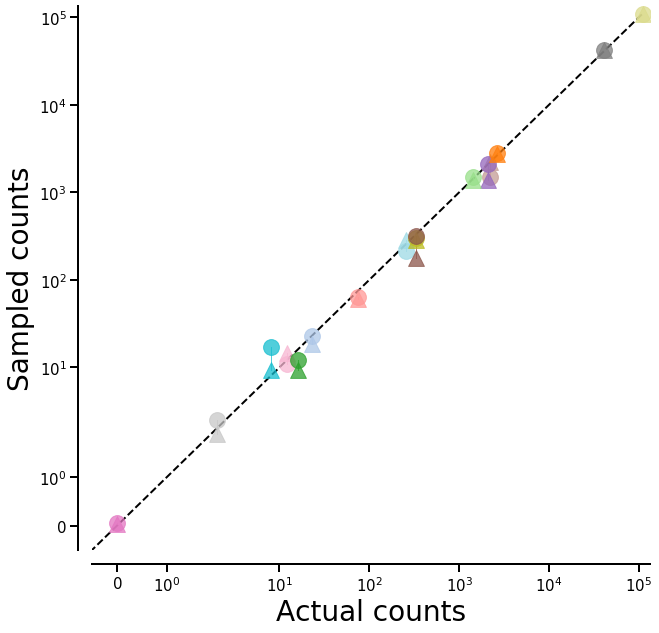

In [46]:
plot_three_neuron_counts_scatter(obs_three_counts, er_three_counts_GE, config_three_counts, 
                                 figsize=(10,10), fname="th300/th300_3_scatter_CGE")